In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
import seaborn as sns

data = pd.read_csv('../../data.csv')

C:\Users\isaro\AppData\Local\Temp\ipykernel_10088\407936447.py:10: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [ ]:

# Calculate average monthly sales across all years
average_monthly_sales = data.groupby('month')['total_price'].sum() / data['year'].nunique()
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=average_monthly_sales.index,
    y=average_monthly_sales.values,
    mode='lines+markers',
    marker=dict(symbol='circle')
))
fig.update_layout(
    title='Average Monthly Sales Throughout the Year',
    xaxis_title='Month',
    yaxis_title='Average Monthly Sales',
    xaxis=dict(tickmode='array', tickvals=list(range(1, 13))),
    yaxis=dict(tickformat=','),
    template='plotly_white'
)
fig.show()

In [14]:

# Calculate total revenue for each month of each year
monthly_revenue = data.groupby(['year', 'month'])['revenue'].sum().reset_index()

# Calculate average monthly revenue across all years
average_monthly_revenue = monthly_revenue.groupby('month')['revenue'].mean()


fig = go.Figure()
fig.add_trace(go.Scatter(
    x=average_monthly_revenue.index,
    y=average_monthly_revenue.values,
    mode='lines+markers',
    marker=dict(symbol='circle')
))

fig.update_layout(
    title='Average Monthly Revenue Throughout the Year',
    xaxis_title='Month',
    yaxis_title='Average Monthly Revenue',
    xaxis=dict(tickmode='array', tickvals=list(range(1, 13))),
    yaxis=dict(tickformat=','),
    template='plotly_white'
)

fig.show()


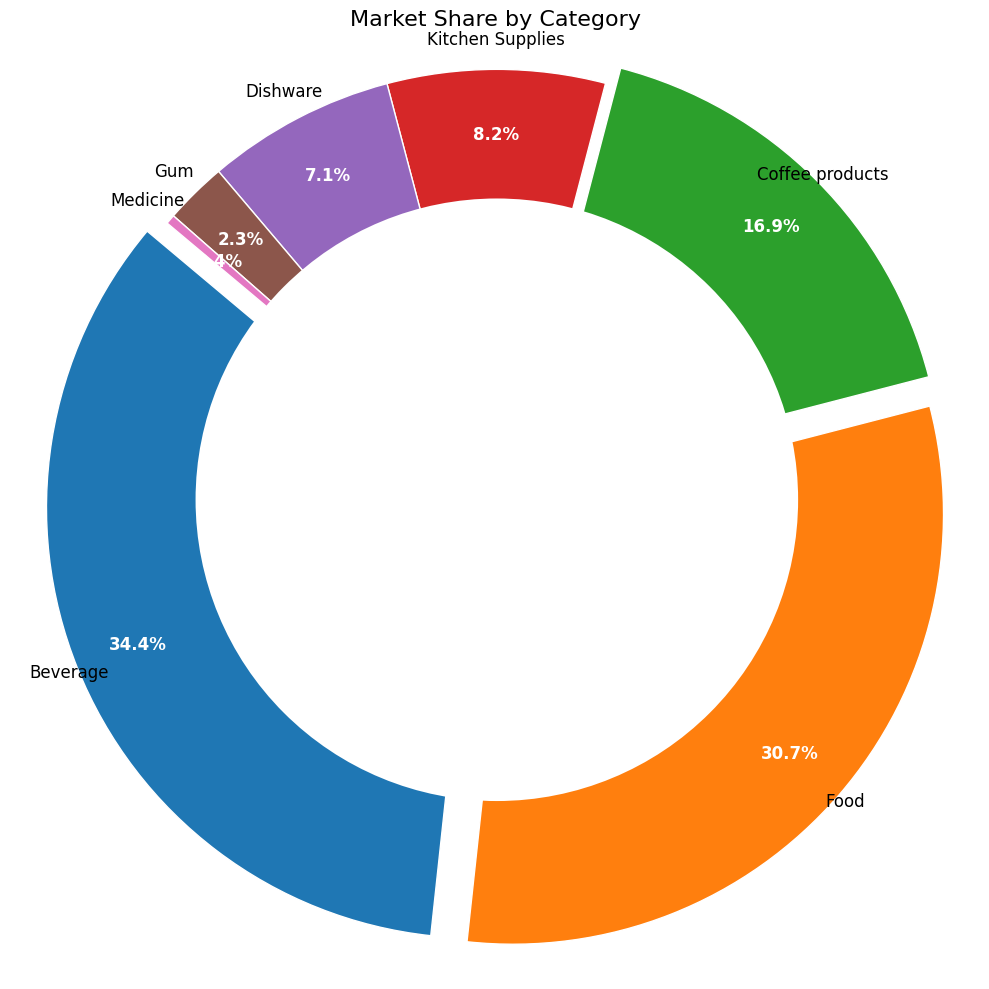

In [7]:

import seaborn as sns
import numpy as np

# Step 1: Define a function to extract the category
def extract_category(description):
    desc = description.strip()
    # Remove 'a. ' prefix if present
    if desc.startswith('a. '):
        desc = desc[3:].strip()
    # If ' - ' exists, take the part before it
    if ' - ' in desc:
        category = desc.split(' - ')[0].strip()
    else:
        # Special cases for descriptions without ' - '
        if desc.startswith('Coffee'):
            category = 'Coffee products'
        elif desc == 'Medicine':
            category = 'Medicine'
        elif desc == 'Kitchen Supplies':
            category = 'Kitchen Supplies'
        else:
            category = desc.split()[0].strip()
    return category

# Apply the function to create the 'Category' column
data['Category'] = data['description'].apply(extract_category)

# Aggregate revenue by 'Category' and 'year'
category_yearly_revenue = data.groupby(['Category', 'year'])['revenue'].sum().reset_index()
category_total_revenue = data.groupby('Category')['revenue'].sum().reset_index()
category_total_revenue = category_total_revenue.sort_values(by='revenue', ascending=False)
total_revenue = category_total_revenue['revenue'].sum()
category_total_revenue['Market_Share'] = (category_total_revenue['revenue'] / total_revenue) * 100


labels = category_total_revenue['Category']
sizes = category_total_revenue['Market_Share']
explode = [0.05 if (size >= 15) else 0 for size in sizes]
colors = sns.color_palette('tab10', n_colors=len(labels))
plt.figure(figsize=(10, 10))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=None,  # We'll add custom labels later
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode,
    pctdistance=0.85,  # Positioning of percentage labels
    textprops={'fontsize': 12, 'color': 'white', 'weight': 'bold'},
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Add category labels outside the pie
for i, (wedge, label) in enumerate(zip(wedges, labels)):
    angle = (wedge.theta2 - wedge.theta1)/2 + wedge.theta1
    x = 1.07 * np.cos(np.deg2rad(angle))
    y = 1.07 * np.sin(np.deg2rad(angle))
    plt.text(x, y, label, ha='center', va='center', fontsize=12)
plt.title('Market Share by Category', fontsize=16)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.tight_layout()

# Show the plot
plt.show()

In [8]:
# Convert 'purchase_date' to datetime and extract 'month' and 'year'
data['purchase_date'] = pd.to_datetime(data['purchase_date'], errors='coerce')
data['month'] = data['purchase_date'].dt.month
data['year'] = data['purchase_date'].dt.year
data = data[data['year'] != 2021]
# Calculate monthly sales for each year
monthly_sales = data.groupby(['year', 'month'])['total_price'].sum().reset_index()

# Pivot the data to have months as rows and years as columns
monthly_sales_pivot = monthly_sales.pivot(index='month', columns='year', values='total_price')

fig = go.Figure()

for year in monthly_sales_pivot.columns:
    fig.add_trace(go.Scatter(
        x=monthly_sales_pivot.index,
        y=monthly_sales_pivot[year],
        mode='lines+markers',
        name=str(year)
    ))

fig.update_layout(
    title='Monthly Sales by Year',
    xaxis_title='Month',
    yaxis_title='Total Monthly Sales',
    xaxis=dict(tickmode='array', tickvals=list(range(1, 13))),
    yaxis=dict(tickformat=','),
    template='plotly_white',
    legend_title='Year'
)

fig.show()


In [9]:
# Identify top N products
top_n = 5
top_products = data.groupby('item_name')['total_price'].sum().nlargest(top_n).index

# Create a modified 'item_name' column with 'Others' for non-top products
data['item_name_mod'] = data['item_name'].where(data['item_name'].isin(top_products), 'Others')

# Prepare monthly sales data for top products and 'Others'
monthly_sales_pivot = (
    data.groupby(['month', 'item_name_mod'])['total_price']
    .sum()
    .unstack()
    .fillna(0)
)

fig = go.Figure()

for column in monthly_sales_pivot.columns:
    fig.add_trace(go.Scatter(
        x=monthly_sales_pivot.index,
        y=monthly_sales_pivot[column],
        mode='lines+markers',
        name=column
    ))

fig.update_layout(
    title='Monthly Sales Trends for Top Products and Others',
    xaxis_title='Month',
    yaxis_title='Total Sales',
    xaxis=dict(tickmode='array', tickvals=list(range(1, 13))),
    yaxis=dict(tickformat=','),
    template='plotly_white',
    legend_title='Product'
)

fig.show()


In [10]:
# Calculate product turnover and get top 10 consistent top-selling products
top_monthly_products = (
    data.groupby(['year', 'month', 'item_name'])['total_price']
    .sum()
    .reset_index()
    .sort_values(['year', 'month', 'total_price'], ascending=[True, True, False])
    .groupby(['year', 'month'])
    .head(3)
)
consistent_top_sellers = (
    top_monthly_products.groupby('item_name')
    .size()
    .reset_index(name='frequency_in_top_3')
    .sort_values(by='frequency_in_top_3', ascending=False)
    .head(10)
)

print("\nTop 10 Consistent Top-Selling Products:")
print(consistent_top_sellers)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=consistent_top_sellers['item_name'],
    y=consistent_top_sellers['frequency_in_top_3'],
    marker_color='skyblue'
))

fig.update_layout(
    title="Top 10 Products by Frequency in Monthly Top 3",
    xaxis_title="Product Name",
    yaxis_title="Months in Top 3",
    xaxis=dict(tickangle=45),
    template='plotly_white'
)

fig.show()



Top 10 Consistent Top-Selling Products:
                                item_name  frequency_in_top_3
14                          Red Bull 12oz                  58
2     K Cups Daily Chef Columbian Supremo                  53
5   K Cups Original Donut Shop Med. Roast                  40
3       K Cups Dunkin Donuts Medium Roast                  24
4         K Cups Folgers Lively Columbian                  18
0                         Honey Packets                    14
13    Muscle Milk Protein Shake Van. 11oz                  10
7        K Cups Р Organic Breakfast Blend                   6
6         K Cups Р  Starbuck's Pike Place                   6
12       Monster Zero Ultra Variety 16 oz                   5


In [11]:

from statsmodels.tsa.seasonal import seasonal_decompose


# If 'purchase_date' is missing, identify the correct column name
if 'purchase_date' not in data.columns:
    # Let's assume the correct column name is 'PurchaseDate'
    if 'PurchaseDate' in data.columns:
        data.rename(columns={'PurchaseDate': 'purchase_date'}, inplace=True)
    else:
        print("Error: 'purchase_date' column not found in the DataFrame.")
        print("Available columns:", data.columns.tolist())
        # Exit or raise an error to prevent further issues
        raise KeyError("'purchase_date' column not found in the DataFrame.")

# Now proceed with the data preprocessing
data['purchase_date'] = pd.to_datetime(data['purchase_date'], errors='coerce')
data = data[data['purchase_date'] <= '2020-12-31']
data = data.dropna(subset=['total_price', 'purchase_date'])
data.set_index('purchase_date', inplace=True)
data['total_price'] = pd.to_numeric(data['total_price'], errors='coerce')

# Proceed with the seasonal decomposition
monthly_sales = data['total_price'].resample('M').sum()

# Plot monthly sales
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_sales.index,
    y=monthly_sales.values,
    mode='lines+markers',
    marker=dict(symbol='circle'),
    name='Total Sales'
))

fig.update_layout(
    title='Monthly Total Sales Over Time (Up to 2020)',
    xaxis_title='Date',
    yaxis_title='Total Sales',
    template='plotly_white'
)

fig.show()

# Perform seasonal decomposition
decomposition = seasonal_decompose(monthly_sales, model='additive')

# Plot the decomposition
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=decomposition.trend.index,
    y=decomposition.trend,
    mode='lines',
    name='Trend'
))

fig.add_trace(go.Scatter(
    x=decomposition.seasonal.index,
    y=decomposition.seasonal,
    mode='lines',
    name='Seasonal'
))

fig.add_trace(go.Scatter(
    x=decomposition.resid.index,
    y=decomposition.resid,
    mode='lines',
    name='Residual'
))

fig.update_layout(
    title='Seasonal Decomposition of Monthly Sales',
    xaxis_title='Date',
    yaxis_title='Value',
    template='plotly_white'
)

fig.show()


C:\Users\isaro\AppData\Local\Temp\ipykernel_10088\3798932952.py:23: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [ ]:

# Step 1: Data Preparation
data['revenue'] = pd.to_numeric(data['revenue'], errors='coerce')
data_clean = data.dropna(subset=['store_region', 'store_district', 'store_sub_district', 'revenue'])

# Step 2: Build Hierarchical Data

# Sub-Districts
sub_districts = data_clean.groupby(['store_region', 'store_district', 'store_sub_district'], as_index=False)['revenue'].sum()
sub_districts['id'] = sub_districts['store_region'] + '/' + sub_districts['store_district'] + '/' + sub_districts['store_sub_district']
sub_districts['parent'] = sub_districts['store_region'] + '/' + sub_districts['store_district']
sub_districts['label'] = sub_districts['store_sub_district']
sub_districts['level'] = 2

# Districts
districts = data_clean.groupby(['store_region', 'store_district'], as_index=False)['revenue'].sum()
districts['id'] = districts['store_region'] + '/' + districts['store_district']
districts['parent'] = districts['store_region']
districts['label'] = districts['store_district']
districts['level'] = 1

# Regions
regions = data_clean.groupby(['store_region'], as_index=False)['revenue'].sum()
regions['id'] = regions['store_region']
regions['parent'] = 'All Regions'
regions['label'] = regions['store_region']
regions['level'] = 0

# Root Node
root = pd.DataFrame({
    'id': ['All Regions'],
    'parent': [''],
    'label': ['All Regions'],
    'revenue': [regions['revenue'].sum()],
    'level': -1  # Root level
})

# Combine DataFrames
all_data = pd.concat(
    [root[['id', 'parent', 'label', 'revenue', 'level']],
     regions[['id', 'parent', 'label', 'revenue', 'level']],
     districts[['id', 'parent', 'label', 'revenue', 'level']],
     sub_districts[['id', 'parent', 'label', 'revenue', 'level']]],
    ignore_index=True
)

# Step 3: Create the Treemap
fig = go.Figure(go.Treemap(
    labels=all_data['label'],
    parents=all_data['parent'],
    ids=all_data['id'],
    values=all_data['revenue'],
    branchvalues='total',
    maxdepth=2,  # Initial view shows up to districts
    textinfo='label+value',
    hovertemplate='<b>%{label}</b><br>Revenue: $%{value:,.2f}<extra></extra>',
    marker=dict(
        colors=all_data['revenue'],
        colorscale='ylgn',
        colorbar=dict(title='Revenue'),
    )))

# Step 4: Update Layout and Traces
fig.update_layout(
    title='Revenue by Store Region, District, and Sub-District',
    margin=dict(t=50, l=25, r=25, b=25)
)

# Adjust font sizes and colors
fig.update_traces(
    insidetextfont=dict(size=14, color='black'),
    selector=dict(type='treemap')
)

# Step 5: Display the Treemap
fig.show()

